In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

from astropy import constants as cste

#%matplotlib widget

## Numerical integration scheme

In [2]:
def glf(N, F, P, i):
    glf_f, glf_p = [], []
    for j in range(0,n_cell):
            if i == 0 and j == 0:
                glf_f.append(0)
                glf_p.append(0)
            if i != 0 and j == 0:
                glf_f.append( (F[i - 1][n_cell - 1] + F[i][j]) * 0.5 - c/2 * (N[i][j] - N[i - 1][n_cell - 1]) )
                glf_p.append( (P[i - 1][n_cell - 1] + P[i][j]) * 0.5 - c/2 * (F[i][j] - F[i - 1][n_cell - 1]) )
            if j != 0:
                glf_f.append( (F[i][j - 1] + F[i][j]) * 0.5 - c/2 * (N[i][j] - N[i][j - 1]) )
                glf_p.append( (P[i][j - 1] + P[i][j]) * 0.5 - c/2 * (F[i][j] - F[i][j - 1]) )
                
    return glf_f, glf_p

In [29]:
def numerical_scheme(n_photon, N, F, P, dt, tf, source_pos, X, continuous=True, chemistery=True):
    for i in source_pos:
        N[0][i] = n_photon
    
    
    
    for i in range(0,int(tf/dt)-1):
        GLF = glf(N,F,P,i)
        glf_f, glf_p = GLF[0], GLF[1]
        
        for k in range(0,n_cell):
            if continuous == True and (k in source_pos):
                if k < n_cell - 1:
                    N[i + 1][k] = n_photon + N[i][k] - dt/dx * (glf_f[k + 1] - glf_f[k])
                    F[i + 1][k] = F[i][k] - dt/dx * (glf_p[k + 1] - glf_p[k])
                else:
                    N[i + 1][k] = n_photon + N[i][k] - dt/dx * (glf_f[0] - glf_f[k])
                    F[i + 1][k] = F[i][k] - dt/dx * (glf_p[0] - glf_p[k])
                    
            else: 
                if k < n_cell - 1:
                    N[i + 1][k] = N[i][k] - dt/dx * (glf_f[k + 1] - glf_f[k])
                    F[i + 1][k] = F[i][k] - dt/dx * (glf_p[k + 1] - glf_p[k])
                else:
                    N[i + 1][k] = N[i][k] - dt/dx * (glf_f[0] - glf_f[k])
                    F[i + 1][k] = F[i][k] - dt/dx * (glf_p[0] - glf_p[k])
                    
            if N[i + 1][k] < 1e-25:
                N[i + 1][k] = 0.0001

            if chemistery == True:
                X[i + 1][k] = third_order_polynom(X[i][k], rho, sigma, N[i + 1][k], T,c)
                test = new_advection_equation(N[i + 1][k], F[i + 1][k], rho, X[i+1][k], X[i][k], T)
                N[i + 1][k] = test[0]
                F[i + 1][k] = test[1]


            f = F[i + 1][k] / (c * N[i + 1][k])
            chi = (3 + 4 * (f**2)) / (5 + 2 * np.sqrt(4 - 3 * (f**2)))
            P[i + 1][k] = chi * N[i + 1][k] * (c**2)
            
        if i%5000 == 0:
            print(i)
                
                
    return N, F, P, X

## Hydrogen photo-ionization

In [4]:
def alpha(T):
    Lambda = (2*157807)/T
    res    = 1.269e-13
    res   *= pow(Lambda, 1.503)
    res   /= pow(1 + (Lambda/0.522)**0.47, 1.923)
    return res

def alpha_b(T):
    Lambda = (2*157807)/T
    res    = 2.753e-14
    res   *= pow(Lambda, 1.5)
    res   /= pow(1 + (Lambda/2.74)**0.407, 2.242)
    return res

def beta(T):
    Lambda = (2*157807)/T
    res    = 21.11*pow(T, (-3/2))*np.exp(-Lambda/2)*pow(Lambda, -1.089)
    res   /=pow(1 + pow(Lambda/0.354, 0.874), 1.01)
    return res

In [21]:
def cooling(T): #collisional excitation cooling in erg cm^3 s^-1
    res  = 7.5e-19/(1.+pow(T/1.0e5,0.5))
    res *= np.exp(-118348./T)
    return res

def heating(): 
    pass

In [42]:
def third_order_polynom(x, rho, sigma, N, T, c):
    m = (alpha_b(T) + beta(T)) * (rho**2) * dt
    n = rho - ((alpha(T) + beta(T)) * rho)/(sigma*c) - alpha_b(T) * (rho**2) * dt - 2 * beta(T) * (rho**2) * dt
    p = -rho * (1 + x) - N - 1/(sigma * c * dt) + (beta(T) * rho)/(sigma * c) + beta(T) * (rho**2) * dt
    q = N + rho * x + x/(sigma * c * dt)

    root = np.roots((m,n,p,q))
    for i in root:
        if i > 0 and i < 1:
            sol = i
    
    return sol

In [43]:
def new_advection_equation(N_explicit, F_explicit, rho, X, x, T):
    N = N_explicit + beta(T)*(rho**2)*(1 - X)*X*dt - alpha_b(T)*(rho**2)*(X**2)*dt - rho*(X-x)
    F = F_explicit / (1 + c*sigma*rho*dt*(1 - X))

    return N, F

## main

In [44]:
n_photon = 5e48 #number of photon per second

sigma = 1.63e-18
dt = 1e8
tf = 6e10
rho = 6
T = 2e3
X = 0.0012



n_cell = 201
dx = 1.9285e19
L = n_cell*dx
c = cste.c.value*1e2

n_gamma = (n_photon)*dt/(dx*dx*dx)


e_thermal = (20 - 13.6)*1.6e-19
rho_cell = rho * (dx*dx*dx)


In [45]:
source_pos = [int(n_cell/2)]
N, F, P, T, x = [], [], [], [], []

for i in range(int(tf/dt)):
    N.append(np.zeros(n_cell))
    F.append(np.zeros(n_cell))
    P.append(np.zeros(n_cell))
    T.append(np.zeros(n_cell))
    x.append(np.ones(n_cell)*X)

In [46]:
L = (n_gamma*dx)/(alpha_b(T)*(rho**2)*dx*dt)
L

21.253877779846096

In [47]:
L*6.25

132.8367361240381

In [48]:
(c*dt)/dx

0.1554536987295826

In [51]:
b = numerical_scheme(n_gamma,N,F,P,dt,tf,source_pos,x,continuous=True,chemistery=False)

0


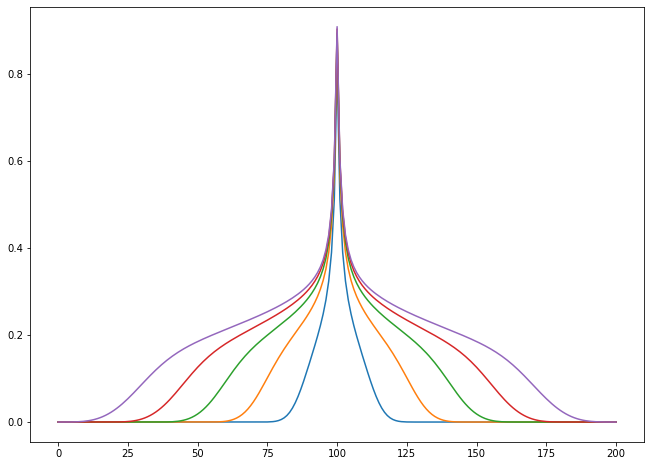

In [52]:
plt.figure(figsize=(11,8))
for i in range(int(tf/dt)-1):
    if i%100 == 0 and i!=0:
        plt.plot(b[0][i])
#plt.savefig("photon_density.png")
plt.show()

In [157]:
print((b[3][-1]))

[0.00139472 0.00117079 0.00116998 0.00116998 0.00116998 0.00116998
 0.00116998 0.00116998 0.00116998 0.00116998 0.00116998 0.00116998
 0.00116998 0.00116998 0.00116998 0.00116998 0.00117116 0.00143413
 0.03872743 0.45092974 0.97361731 0.99513413 0.99756233 0.99840448
 0.99882822 0.99908766 0.99926938 0.99941229 0.99953853 0.9996637
 0.99979667 0.9996637  0.99953853 0.99941229 0.99926938 0.99908766
 0.99882822 0.99840448 0.99756233 0.99513413 0.97361731 0.45092974
 0.03872743 0.00143413 0.00117116 0.00116998 0.00116998 0.00116998
 0.00116998 0.00116998 0.00116998 0.00116998 0.00116998 0.00116998
 0.00116998 0.00116998 0.00116998 0.00116998 0.00117079 0.00139472
 0.02267497]


In [ ]:
# diffusion numérique -> un peu photons loin
#lissage par GLF du dirac -> front d'onde theorique suit pas excatement la simu 

In [14]:
324077928963.48486328

324077928963.48486

In [ ]:
XAxis = np.arange(n_cell)
fig, ax = plt.subplots()

def animate(i):
    #a[0][i] = np.amax(a[0][i])
    ax.clear()
    ax.set_ylim(0, np.amax(a[0][i]))
    line, = ax.plot(XAxis, a[0][i], c='red')
    line1, = ax.plot(XAxis, b[0][i], c='blue')
    return line, line1,

ani = FuncAnimation(fig, animate, interval = 0.1, blit=True, repeat=True, frames=1000)
ani.save("Gngn.gif", dpi = 300, writer = PillowWriter(fps=25))